In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

from dyck_k_generator import constants

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [4]:
if device == "mps":
    torch.mps.empty_cache()
elif device == "cuda:0":
    torch.cuda.empty_cache()

In [5]:
torch.manual_seed(42)

In [69]:
k = 1

In [70]:
from dyck_k_generator.generator import generate_dataset

path = generate_dataset(
    n=5_000,
    k=k,
    min_length=0,
    max_length=10,
    balanced=0.5,
)

Generating unbalanced strings: 100%|██████████| 2500/2500 [00:00<00:00, 36984.98it/s]
Saving dataset to data/dyck-1_5000-samples_10-len_p05.jsonl: 100%|██████████| 5000/5000 [00:00<00:00, 692975.58it/s]

Dataset saved to data/dyck-1_5000-samples_10-len_p05.jsonl


In [71]:
VOCAB = "".join(["".join((key, value)) for key, value in list(constants.BRACKETS.items())[:k]])
VOCAB

'()'

In [72]:
from dataset.dataset import DyckLanguageDataset

In [73]:
dataset = DyckLanguageDataset(path, VOCAB).to(device)

Loaded 5000 samples from data/dyck-1_5000-samples_10-len_p05.jsonl


Tokenizing strings: 100%|██████████| 5000/5000 [00:00<00:00, 22751.90it/s]


In [74]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = int(0.15 * train_size)
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [75]:
from torch.utils.data import DataLoader

In [76]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

# Manual Transformer + BERTViz


In [77]:
from transformer.hooked_transformer import (
    TransformerClassifier,
    TransformerClassifierConfig,
    pad_token_mask,
)

In [78]:
model_config = TransformerClassifierConfig(
    vocab_size=len(VOCAB),
    d_model=512,
    n_heads=1,
    dim_ff=1024,
    n_layers=1,
    n_classes=2,
    max_seq_len=10,
    pos_enc="none",
)

In [79]:
model_bidirectional = TransformerClassifier(model_config)

In [80]:
model_bidirectional.to(device)

TransformerClassifier(
  (embedding): Embedding(5, 512)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): EncoderBlock(
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=512, out_features=512, bias=True)
          (k_linear): Linear(in_features=512, out_features=512, bias=True)
          (v_linear): Linear(in_features=512, out_features=512, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (residual_dropout): Dropout(p=0.1, inplace=False)
          (attn): ScaledDotProductAttention()
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (ff): Sequential(
          (0): Linear(in_features=512, out_features=1024, bias=True)
          (1): Dropout(p=0.1, inplace=False)
          (2): ReLU(inplace=True)
          (3): Linear(in_features=1024, out_features=512, bias=True)
        )
        (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((512,)

In [81]:
import torch.optim as optim

crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model_bidirectional.parameters(), lr=1e-6)

In [82]:
train_loss, train_acc, val_loss, val_acc = model_bidirectional.train_model(
    device=device,
    epochs=50,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask="bidirectional",
)

Epoch 1/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 43.3895 | Train Acc: 53.75%
Val Loss: 6.5091 | Val Acc: 63.17%
Epoch 2/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 39.7309 | Train Acc: 69.70%
Val Loss: 5.8722 | Val Acc: 100.00%
Epoch 3/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 35.8709 | Train Acc: 83.53%
Val Loss: 5.2595 | Val Acc: 100.00%
Epoch 4/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 32.6496 | Train Acc: 88.88%
Val Loss: 4.7017 | Val Acc: 100.00%
Epoch 5/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 29.7830 | Train Acc: 92.70%
Val Loss: 4.1940 | Val Acc: 100.00%
Epoch 6/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 27.0044 | Train Acc: 94.97%
Val Loss: 3.7812 | Val Acc: 100.00%
Epoch 7/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 24.5929 | Train Acc: 96.12%
Val Loss: 3.4353 | Val Acc: 100.00%
Epoch 8/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 22.3921 | Train Acc: 97.28%
Val Loss: 3.0652 | Val Acc: 100.00%
Epoch 9/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 20.0364 | Train Acc: 98.80%
Val Loss: 2.7245 | Val Acc: 100.00%
Epoch 10/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 18.1806 | Train Acc: 98.95%
Val Loss: 2.4119 | Val Acc: 100.00%
Epoch 11/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 16.1913 | Train Acc: 99.72%
Val Loss: 2.1406 | Val Acc: 100.00%
Epoch 12/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 14.6121 | Train Acc: 99.80%
Val Loss: 1.8230 | Val Acc: 100.00%
Epoch 13/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 12.9031 | Train Acc: 99.95%
Val Loss: 1.5732 | Val Acc: 100.00%
Epoch 14/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 11.3187 | Train Acc: 99.98%
Val Loss: 1.3515 | Val Acc: 100.00%
Epoch 15/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 9.9936 | Train Acc: 100.00%
Val Loss: 1.1623 | Val Acc: 100.00%
Epoch 16/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 8.7327 | Train Acc: 100.00%
Val Loss: 0.9996 | Val Acc: 100.00%
Epoch 17/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 7.6285 | Train Acc: 100.00%
Val Loss: 0.8324 | Val Acc: 100.00%
Epoch 18/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 6.6076 | Train Acc: 100.00%
Val Loss: 0.7104 | Val Acc: 100.00%
Epoch 19/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 5.7575 | Train Acc: 100.00%
Val Loss: 0.6040 | Val Acc: 100.00%
Epoch 20/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 5.0083 | Train Acc: 100.00%
Val Loss: 0.5082 | Val Acc: 100.00%
Epoch 21/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 4.3538 | Train Acc: 100.00%
Val Loss: 0.4473 | Val Acc: 100.00%
Epoch 22/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 3.7654 | Train Acc: 100.00%
Val Loss: 0.3632 | Val Acc: 100.00%
Epoch 23/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 3.2852 | Train Acc: 100.00%
Val Loss: 0.3092 | Val Acc: 100.00%
Epoch 24/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 2.8573 | Train Acc: 100.00%
Val Loss: 0.2598 | Val Acc: 100.00%
Epoch 25/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 2.5548 | Train Acc: 100.00%
Val Loss: 0.2253 | Val Acc: 100.00%
Epoch 26/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 2.2059 | Train Acc: 100.00%
Val Loss: 0.1908 | Val Acc: 100.00%
Epoch 27/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 1.9347 | Train Acc: 100.00%
Val Loss: 0.1653 | Val Acc: 100.00%
Epoch 28/50


  0%|          | 0/63 [00:00<?, ?it/s]

In [66]:
test_loss, test_acc = model_bidirectional.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask="bidirectional",
)

  0%|          | 0/50 [00:00<?, ?it/s]

Test Loss: 0.0107 | Test Acc: 100.00%


train_acc,▁▅▆▇▇▇▇█████████████████████████████████
train_loss,█▆▆▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▂▃▃▄███████████████████████████████████
val_loss,█▆▅▆▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,100.0
train_loss,0.00084
val_acc,100.0
val_loss,0.00027


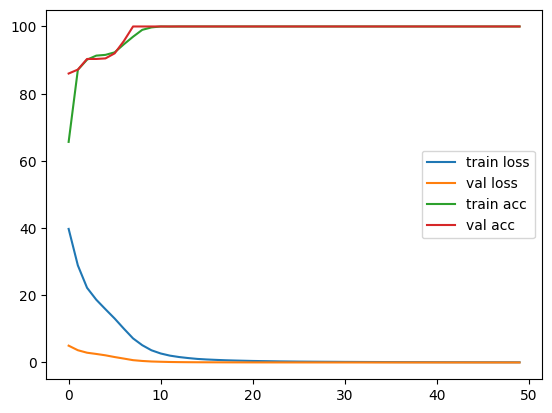

In [67]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.plot(train_acc, label="train acc")
plt.plot(val_acc, label="val acc")
plt.legend()
plt.show()

In [22]:
model_causal = TransformerClassifier(model_config).to(device)

In [23]:
crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model_causal.parameters(), lr=1e-6)

In [24]:
train_loss, train_acc, val_loss, val_acc = model_causal.train_model(
    device=device,
    epochs=50,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask="causal",
)

Epoch 1/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.6898 | Train Accuracy: 49.41%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 90.0101 | Train Acc: 49.56%
Val Loss: 13.1888 | Val Acc: 46.75%
Epoch 2/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.6793 | Train Accuracy: 50.14%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 88.4254 | Train Acc: 49.75%
Val Loss: 13.2204 | Val Acc: 46.75%
Epoch 3/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.6824 | Train Accuracy: 49.05%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 88.3588 | Train Acc: 49.25%
Val Loss: 13.2025 | Val Acc: 46.75%
Epoch 4/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.7086 | Train Accuracy: 49.70%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 88.6866 | Train Acc: 49.10%
Val Loss: 13.2177 | Val Acc: 46.75%
Epoch 5/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.7091 | Train Accuracy: 49.23%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 88.3331 | Train Acc: 49.48%
Val Loss: 13.1966 | Val Acc: 46.75%
Epoch 6/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.7212 | Train Accuracy: 50.28%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 88.4701 | Train Acc: 49.94%
Val Loss: 13.1771 | Val Acc: 46.75%
Epoch 7/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.7057 | Train Accuracy: 50.80%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 88.1947 | Train Acc: 50.82%
Val Loss: 13.1692 | Val Acc: 53.25%
Epoch 8/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.7219 | Train Accuracy: 50.56%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 87.6630 | Train Acc: 50.84%
Val Loss: 13.2084 | Val Acc: 46.75%
Epoch 9/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.6924 | Train Accuracy: 50.38%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 88.3227 | Train Acc: 50.19%
Val Loss: 13.2169 | Val Acc: 46.75%
Epoch 10/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.7390 | Train Accuracy: 49.84%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 87.9380 | Train Acc: 50.31%
Val Loss: 13.2131 | Val Acc: 46.75%
Epoch 11/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.7039 | Train Accuracy: 49.45%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 88.2046 | Train Acc: 49.70%
Val Loss: 13.1783 | Val Acc: 46.75%
Epoch 12/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.6824 | Train Accuracy: 49.55%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 88.3223 | Train Acc: 49.98%
Val Loss: 13.2231 | Val Acc: 46.75%
Epoch 13/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.6923 | Train Accuracy: 50.44%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 87.8710 | Train Acc: 50.60%
Val Loss: 13.1511 | Val Acc: 53.25%
Epoch 14/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.6635 | Train Accuracy: 48.22%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 88.7486 | Train Acc: 48.62%
Val Loss: 13.2016 | Val Acc: 46.75%
Epoch 15/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.7037 | Train Accuracy: 49.48%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 88.2746 | Train Acc: 49.71%
Val Loss: 13.2002 | Val Acc: 46.75%
Epoch 16/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.7156 | Train Accuracy: 49.86%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 88.1358 | Train Acc: 50.24%
Val Loss: 13.1818 | Val Acc: 46.75%
Epoch 17/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.6828 | Train Accuracy: 49.61%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 88.3999 | Train Acc: 49.56%
Val Loss: 13.1783 | Val Acc: 46.75%
Epoch 18/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.7092 | Train Accuracy: 50.33%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 87.8612 | Train Acc: 50.38%
Val Loss: 13.2204 | Val Acc: 46.75%
Epoch 19/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.7056 | Train Accuracy: 50.33%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 87.9696 | Train Acc: 50.20%
Val Loss: 13.2189 | Val Acc: 46.75%
Epoch 20/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.7329 | Train Accuracy: 49.66%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 88.0071 | Train Acc: 49.66%
Val Loss: 13.1976 | Val Acc: 46.75%
Epoch 21/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.7153 | Train Accuracy: 50.17%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 87.9921 | Train Acc: 50.24%
Val Loss: 13.2292 | Val Acc: 46.75%
Epoch 22/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.7162 | Train Accuracy: 49.45%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 88.0048 | Train Acc: 49.36%
Val Loss: 13.1960 | Val Acc: 46.75%
Epoch 23/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.7296 | Train Accuracy: 49.38%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 88.0899 | Train Acc: 49.70%
Val Loss: 13.1864 | Val Acc: 46.75%
Epoch 24/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.7166 | Train Accuracy: 50.31%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 87.5591 | Train Acc: 50.36%
Val Loss: 13.1876 | Val Acc: 46.75%
Epoch 25/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.6832 | Train Accuracy: 50.69%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 87.8728 | Train Acc: 50.21%
Val Loss: 13.1601 | Val Acc: 53.25%
Epoch 26/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.6893 | Train Accuracy: 50.89%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 87.6100 | Train Acc: 50.29%
Val Loss: 13.2100 | Val Acc: 46.75%
Epoch 27/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.7174 | Train Accuracy: 48.88%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 87.9963 | Train Acc: 49.00%
Val Loss: 13.2111 | Val Acc: 46.75%
Epoch 28/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.6977 | Train Accuracy: 49.58%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 88.0212 | Train Acc: 49.24%
Val Loss: 13.1906 | Val Acc: 46.75%
Epoch 29/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.7097 | Train Accuracy: 49.56%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 87.8979 | Train Acc: 49.85%
Val Loss: 13.1928 | Val Acc: 46.75%
Epoch 30/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.7155 | Train Accuracy: 48.94%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 88.0348 | Train Acc: 49.00%
Val Loss: 13.1925 | Val Acc: 46.75%
Epoch 31/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.7014 | Train Accuracy: 50.20%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 87.6020 | Train Acc: 50.35%
Val Loss: 13.1814 | Val Acc: 46.75%
Epoch 32/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.7202 | Train Accuracy: 49.25%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 87.7592 | Train Acc: 49.41%
Val Loss: 13.1869 | Val Acc: 46.75%
Epoch 33/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.6881 | Train Accuracy: 50.14%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 87.8036 | Train Acc: 50.00%
Val Loss: 13.1724 | Val Acc: 46.75%
Epoch 34/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.6853 | Train Accuracy: 49.95%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 87.5778 | Train Acc: 50.16%
Val Loss: 13.1756 | Val Acc: 46.75%
Epoch 35/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.7004 | Train Accuracy: 51.22%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 87.5971 | Train Acc: 50.74%
Val Loss: 13.1799 | Val Acc: 46.75%
Epoch 36/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.6830 | Train Accuracy: 50.47%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 87.5043 | Train Acc: 50.00%
Val Loss: 13.2101 | Val Acc: 46.75%
Epoch 37/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.7202 | Train Accuracy: 48.52%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 87.6752 | Train Acc: 49.11%
Val Loss: 13.2038 | Val Acc: 46.75%
Epoch 38/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.6847 | Train Accuracy: 49.11%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 87.6276 | Train Acc: 49.84%
Val Loss: 13.2055 | Val Acc: 46.75%
Epoch 39/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.7286 | Train Accuracy: 49.36%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 87.8388 | Train Acc: 49.25%
Val Loss: 13.1920 | Val Acc: 46.75%
Epoch 40/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.6968 | Train Accuracy: 49.89%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 87.5401 | Train Acc: 50.06%
Val Loss: 13.1930 | Val Acc: 46.75%
Epoch 41/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.7060 | Train Accuracy: 50.30%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 87.6097 | Train Acc: 50.21%
Val Loss: 13.2218 | Val Acc: 46.75%
Epoch 42/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.6789 | Train Accuracy: 50.27%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 87.6309 | Train Acc: 50.15%
Val Loss: 13.1568 | Val Acc: 53.25%
Epoch 43/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.7071 | Train Accuracy: 49.52%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 87.5603 | Train Acc: 49.96%
Val Loss: 13.1992 | Val Acc: 46.75%
Epoch 44/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.7133 | Train Accuracy: 49.98%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 87.6349 | Train Acc: 50.15%
Val Loss: 13.1832 | Val Acc: 46.75%
Epoch 45/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.6957 | Train Accuracy: 49.59%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 87.6034 | Train Acc: 49.31%
Val Loss: 13.1839 | Val Acc: 46.75%
Epoch 46/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.7133 | Train Accuracy: 49.16%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 87.8918 | Train Acc: 49.34%
Val Loss: 13.1670 | Val Acc: 53.25%
Epoch 47/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.7090 | Train Accuracy: 49.48%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 87.7043 | Train Acc: 49.12%
Val Loss: 13.2079 | Val Acc: 46.75%
Epoch 48/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.6914 | Train Accuracy: 50.88%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 87.3440 | Train Acc: 50.59%
Val Loss: 13.2533 | Val Acc: 46.75%
Epoch 49/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.6871 | Train Accuracy: 50.84%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 87.4105 | Train Acc: 50.54%
Val Loss: 13.1938 | Val Acc: 46.75%
Epoch 50/50


  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.6963 | Train Accuracy: 50.12%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 87.4042 | Train Acc: 50.25%
Val Loss: 13.1888 | Val Acc: 46.75%


In [25]:
test_loss, test_acc = model_causal.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask="causal",
)

  0%|          | 0/100 [00:00<?, ?it/s]

Validation Loss: 69.3175 | Validation Accuracy: 50.25%
Test Loss: 69.3175 | Test Acc: 50.25%


train_acc,▂▃▁▃▃▄▄▃▃▂▃▃▃▂▃▃▃▂▃▅▄▂▃▂▃▂▂▄▃▁▂▃▃▃█▂▂▂▄▂
train_loss,▄▃▆▃▄▆█▇▅▅▄▆▃▆▇▆▆▆▇▆▆▆▅▅▅▇▅▆▇▆▅▅▇▁▄▅█▄▇▆
val_acc,▃▄▃▆▃▄▄▅▄█▃▄▄▄▅▄▃▂▄▄▃▁▆▄▄▅▅▃▅▅▅▄▃█▁▄▃▄▆▆
val_loss,▄▁▄▅▃▃▄▃█▄▅▄▃▃▄▄▄▄▂▅▄▅▄▄▃▃▅▂▅▅▄▃▄▅▆▄▅▃▃▂
train_acc,50.25
train_loss,0.6866
val_acc,50.25
val_loss,0.68628


# Attention plots:


In [27]:
from transformer_viz.visualizer import min_max_normalize, plot_attn_matrices

In [28]:
from dataset.dataset import DyckLanguageTokenizer

In [29]:
from dyck_k_generator.checker import is_dyck_word

In [30]:
model_bidirectional(
    DyckLanguageTokenizer(VOCAB).tokenize(")()(").to(device),
    mask=pad_token_mask(DyckLanguageTokenizer(VOCAB).tokenize(")()(").to(device)),
).max(1)

Tokenizing strings: 100%|██████████| 1/1 [00:00<00:00, 38479.85it/s]


torch.return_types.max(
values=tensor([7.5208], device='mps:0', grad_fn=<MaxBackward0>),
indices=tensor([1], device='mps:0'))

In [31]:
batch = [
    (")))))))(((((((", "((((((()))))))", ")()()()()()()(", "()()()()()()()"),
    torch.tensor(
        [
            is_dyck_word(")))))))(((((((", 1),
            is_dyck_word("((((((()))))))", 1),
            is_dyck_word(")()()()()()()(", 1),
            is_dyck_word("()()()()()()()", 1),
        ],
        dtype=torch.float32,
        device=device,
    ),
    torch.tensor(
        [
            DyckLanguageTokenizer(VOCAB).tokenize(")))))))(((((((").tolist()[0],
            DyckLanguageTokenizer(VOCAB).tokenize("((((((()))))))").tolist()[0],
            DyckLanguageTokenizer(VOCAB).tokenize(")()()()()()()(").tolist()[0],
            DyckLanguageTokenizer(VOCAB).tokenize("()()()()()()()").tolist()[0],
        ],
        device=device,
    ),
]
batch

Tokenizing strings: 100%|██████████| 1/1 [00:00<00:00, 25575.02it/s]


[(')))))))(((((((', '((((((()))))))', ')()()()()()()(', '()()()()()()()'),
 tensor([0., 1., 0., 1.], device='mps:0'),
 tensor([[0., 4., 4., 4., 4., 4., 4., 4., 3., 3., 3., 3., 3., 3., 3., 2.],
         [0., 3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 2.],
         [0., 4., 3., 4., 3., 4., 3., 4., 3., 4., 3., 4., 3., 4., 3., 2.],
         [0., 3., 4., 3., 4., 3., 4., 3., 4., 3., 4., 3., 4., 3., 4., 2.]],
        device='mps:0')]

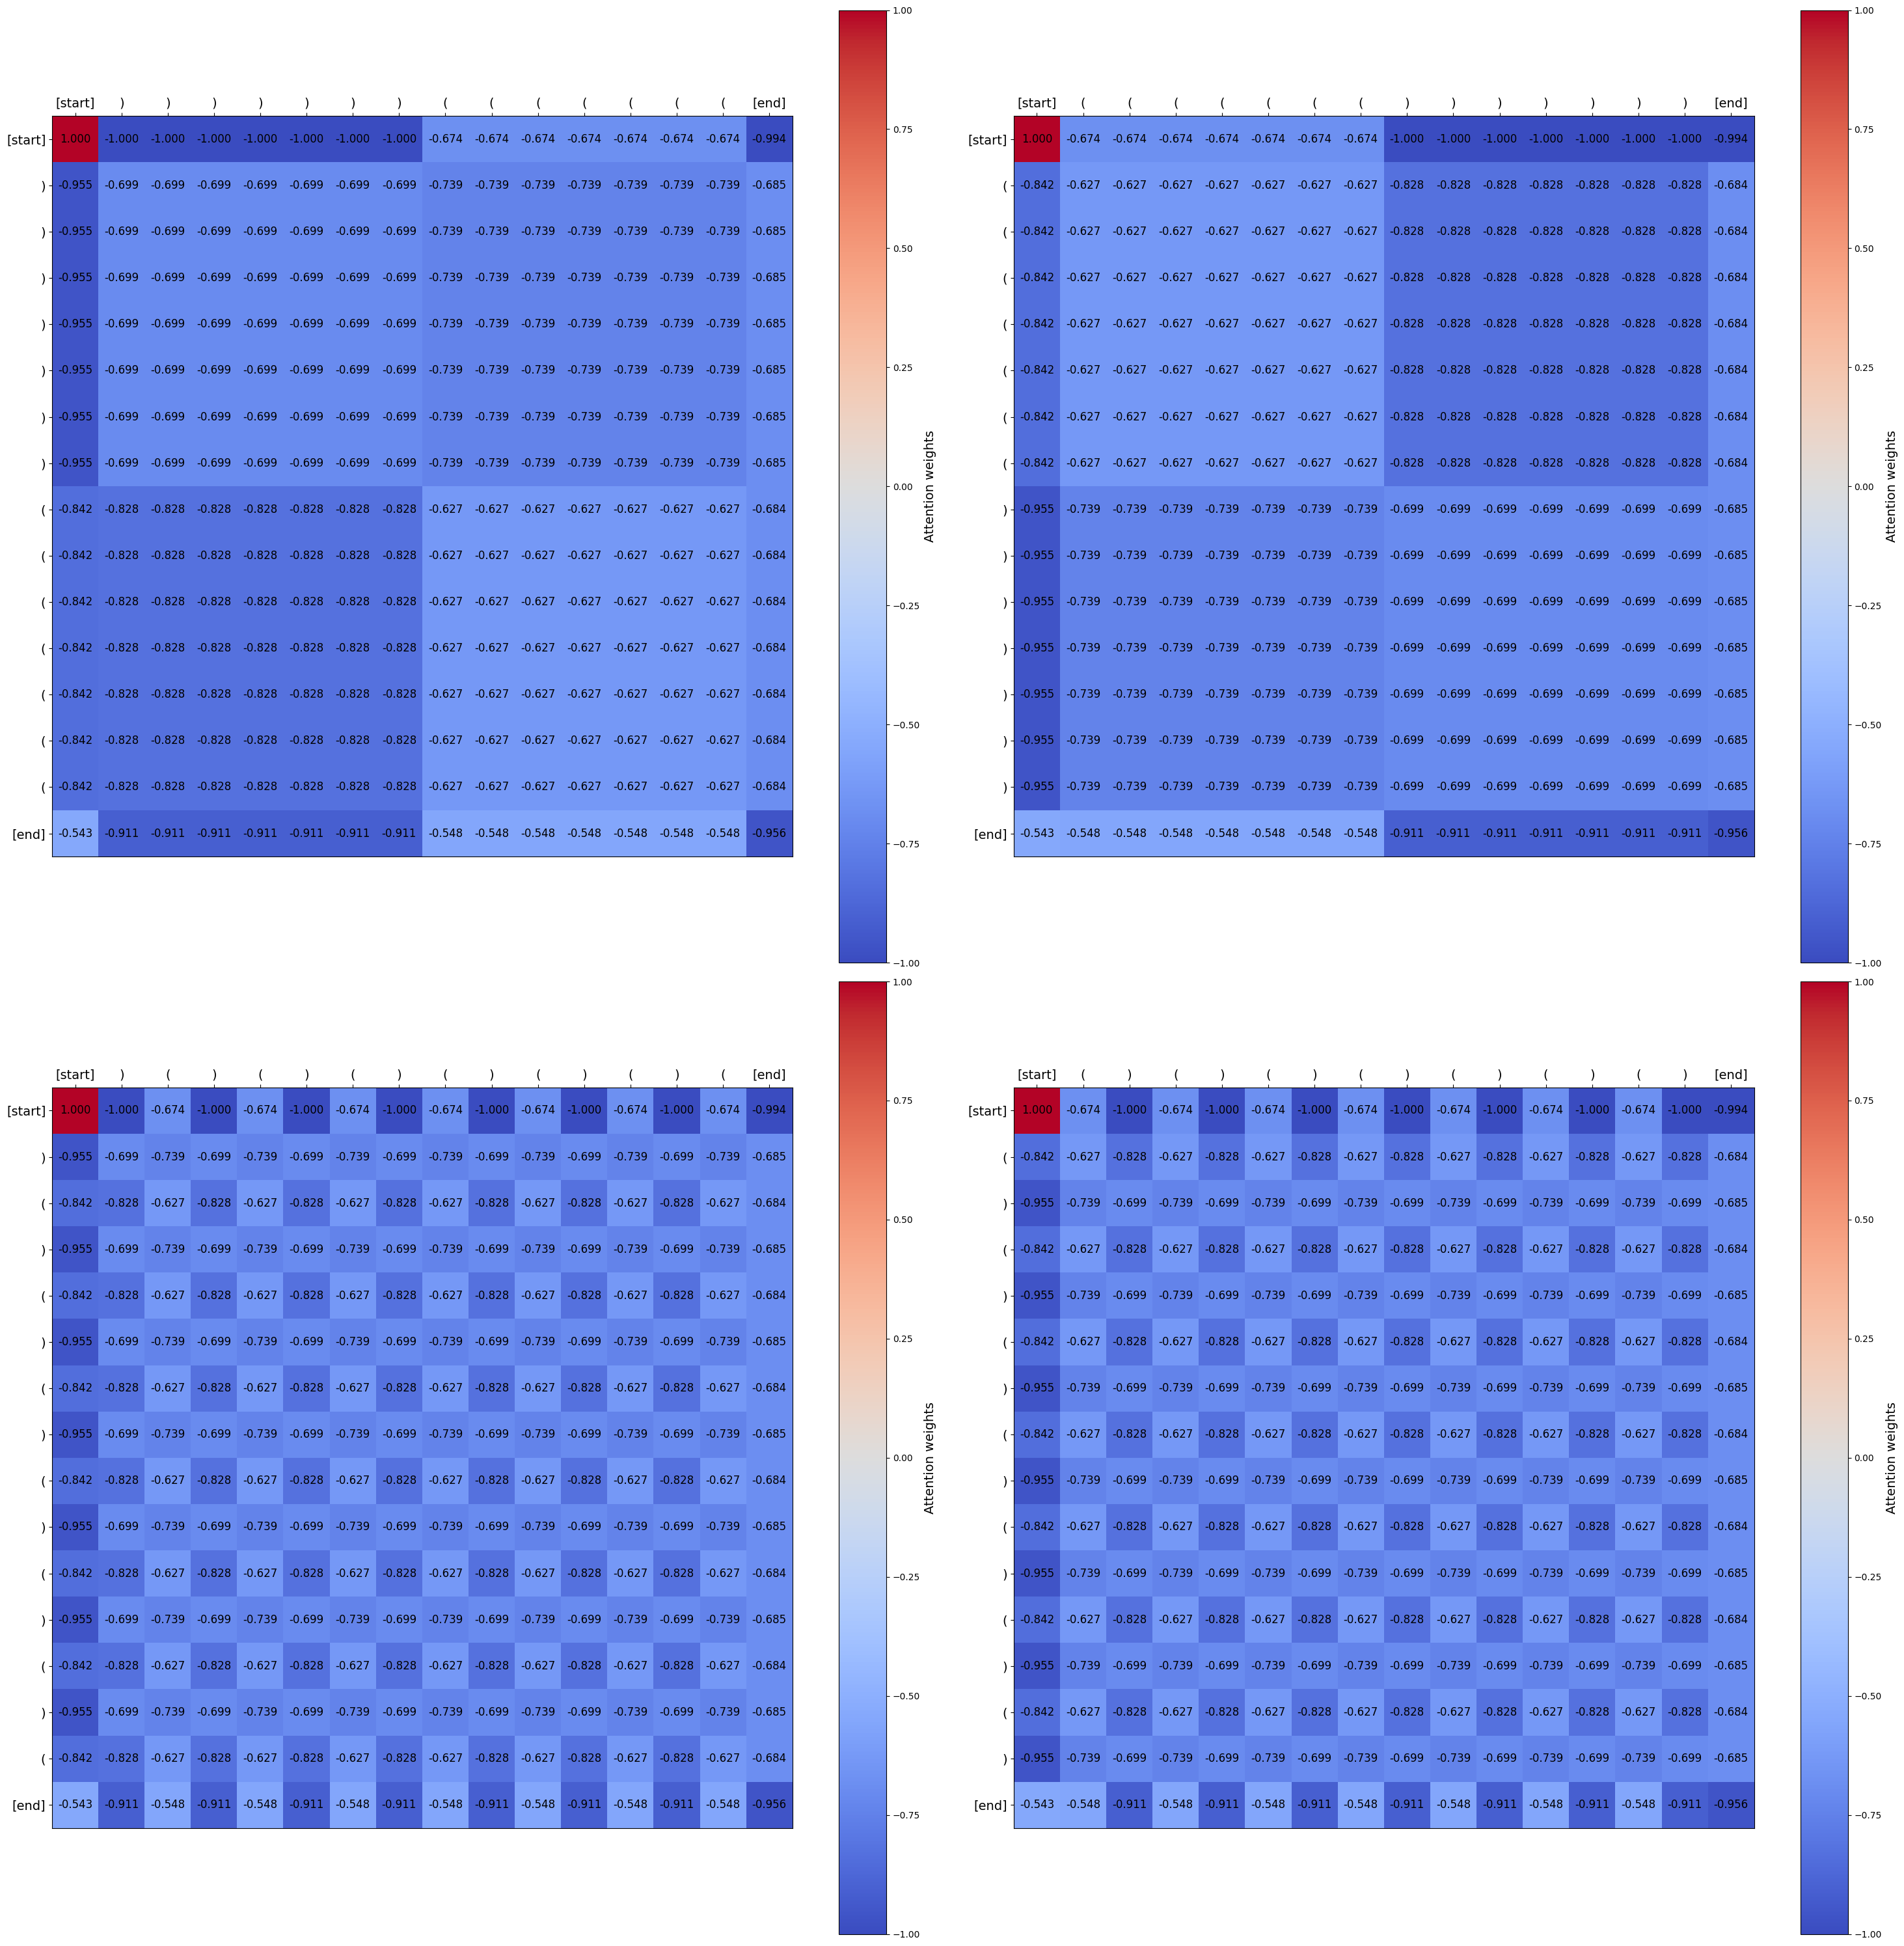

In [32]:
plot_attn_matrices(VOCAB, batch, model_bidirectional, min_max_normalize, pad_token_mask)

In [33]:
minimax_norm = min_max_normalize(attn_matrices[0][0][0].cpu().detach().numpy())

In [34]:
minimax_norm[0][0]

np.float32(1.0)

# Experiment 2

We will experiment with the same grammar, using a causal mask instead of a bidirectional one.


In [35]:
model_two = TransformerClassifier(model_config).to(device)

# Experiment 3

Dyck-3


In [36]:
k = 3

In [49]:
path = generate_dataset(
    n=5_000,
    k=3,
    min_length=0,
    max_length=10,
    balanced=0.5,
)

Generating unbalanced strings: 100%|██████████| 2500/2500 [00:00<00:00, 61508.36it/s]
Saving dataset to data/dyck-3_5000-samples_10-len_p05.jsonl: 100%|██████████| 5000/5000 [00:00<00:00, 648429.91it/s]

Dataset saved to data/dyck-3_5000-samples_10-len_p05.jsonl


In [50]:
VOCAB = "".join(["".join((key, value)) for key, value in list(constants.BRACKETS.items())[:k]])
VOCAB

'()[]{}'

In [51]:
dataset_dyck_2 = DyckLanguageDataset(path, VOCAB).to(device)

Loaded 5000 samples from data/dyck-3_5000-samples_10-len_p05.jsonl


Tokenizing strings: 100%|██████████| 5000/5000 [00:00<00:00, 437134.34it/s]


In [52]:
train_size = int(0.8 * len(dataset_dyck_2))
val_size = int(0.15 * train_size)
test_size = len(dataset_dyck_2) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset_dyck_2, [train_size, val_size, test_size])

In [53]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

In [54]:
model_config = TransformerClassifierConfig(
    vocab_size=len(VOCAB),
    d_model=512,
    n_heads=1,
    dim_ff=1024,
    n_layers=1,
    n_classes=2,
    max_seq_len=10,
)

In [55]:
model = TransformerClassifier(model_config).to(device)

In [56]:
crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-6)

In [57]:
train_loss, train_acc, val_loss, val_acc = model.train_model(
    device=device,
    epochs=15,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask="bidirectional",
)

Epoch 1/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 45.4965 | Train Acc: 46.90%
Val Loss: 6.8179 | Val Acc: 47.33%
Epoch 2/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 40.2361 | Train Acc: 68.42%
Val Loss: 5.7298 | Val Acc: 76.67%
Epoch 3/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 33.1286 | Train Acc: 82.17%
Val Loss: 4.7637 | Val Acc: 76.67%
Epoch 4/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 27.3673 | Train Acc: 82.88%
Val Loss: 4.0257 | Val Acc: 78.33%
Epoch 5/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 22.7935 | Train Acc: 85.52%
Val Loss: 3.1552 | Val Acc: 82.67%
Epoch 6/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 17.5154 | Train Acc: 94.20%
Val Loss: 2.1939 | Val Acc: 100.00%
Epoch 7/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 12.7158 | Train Acc: 98.85%
Val Loss: 1.6025 | Val Acc: 100.00%
Epoch 8/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 9.3330 | Train Acc: 99.83%
Val Loss: 1.1484 | Val Acc: 100.00%
Epoch 9/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 7.1773 | Train Acc: 100.00%
Val Loss: 0.8538 | Val Acc: 100.00%
Epoch 10/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 5.5805 | Train Acc: 99.98%
Val Loss: 0.6435 | Val Acc: 100.00%
Epoch 11/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 4.3724 | Train Acc: 100.00%
Val Loss: 0.5017 | Val Acc: 100.00%
Epoch 12/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 3.5133 | Train Acc: 100.00%
Val Loss: 0.3945 | Val Acc: 100.00%
Epoch 13/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 2.8612 | Train Acc: 100.00%
Val Loss: 0.3171 | Val Acc: 100.00%
Epoch 14/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 2.3431 | Train Acc: 100.00%
Val Loss: 0.2575 | Val Acc: 100.00%
Epoch 15/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 1.9842 | Train Acc: 100.00%
Val Loss: 0.2114 | Val Acc: 100.00%


In [58]:
test_loss, test_acc = model.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask="bidirectional",
)

  0%|          | 0/50 [00:00<?, ?it/s]

Test Loss: 0.9201 | Test Acc: 100.00%


train_acc,▁▁▂▃▄▅▆▆▆▆▆▆▆▇▇▇████████████████████████
train_loss,█▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▂▁▄▅▅▅▅▅▅▆██████████████████████████████
val_loss,██▇▇▆▆▅▅▅▄▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,100.0
train_loss,0.02925
val_acc,100.0
val_loss,0.01527


In [59]:
batch = next(iter(test_dataloader))
batch

[('[[()]][]{}', ')', '(){[[]]}', ')', '{()[]}', '([])', '[{}]({})', '{(())}'),
 tensor([1., 0., 1., 0., 1., 1., 1., 1.], device='mps:0'),
 tensor([[0., 5., 5., 3., 4., 6., 6., 5., 6., 7., 8., 2.],
         [0., 4., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 3., 4., 7., 5., 5., 6., 6., 8., 2., 1., 1.],
         [0., 4., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 7., 3., 4., 5., 6., 8., 2., 1., 1., 1., 1.],
         [0., 3., 5., 6., 4., 2., 1., 1., 1., 1., 1., 1.],
         [0., 5., 7., 8., 6., 3., 7., 8., 4., 2., 1., 1.],
         [0., 7., 3., 3., 4., 4., 8., 2., 1., 1., 1., 1.]], device='mps:0')]

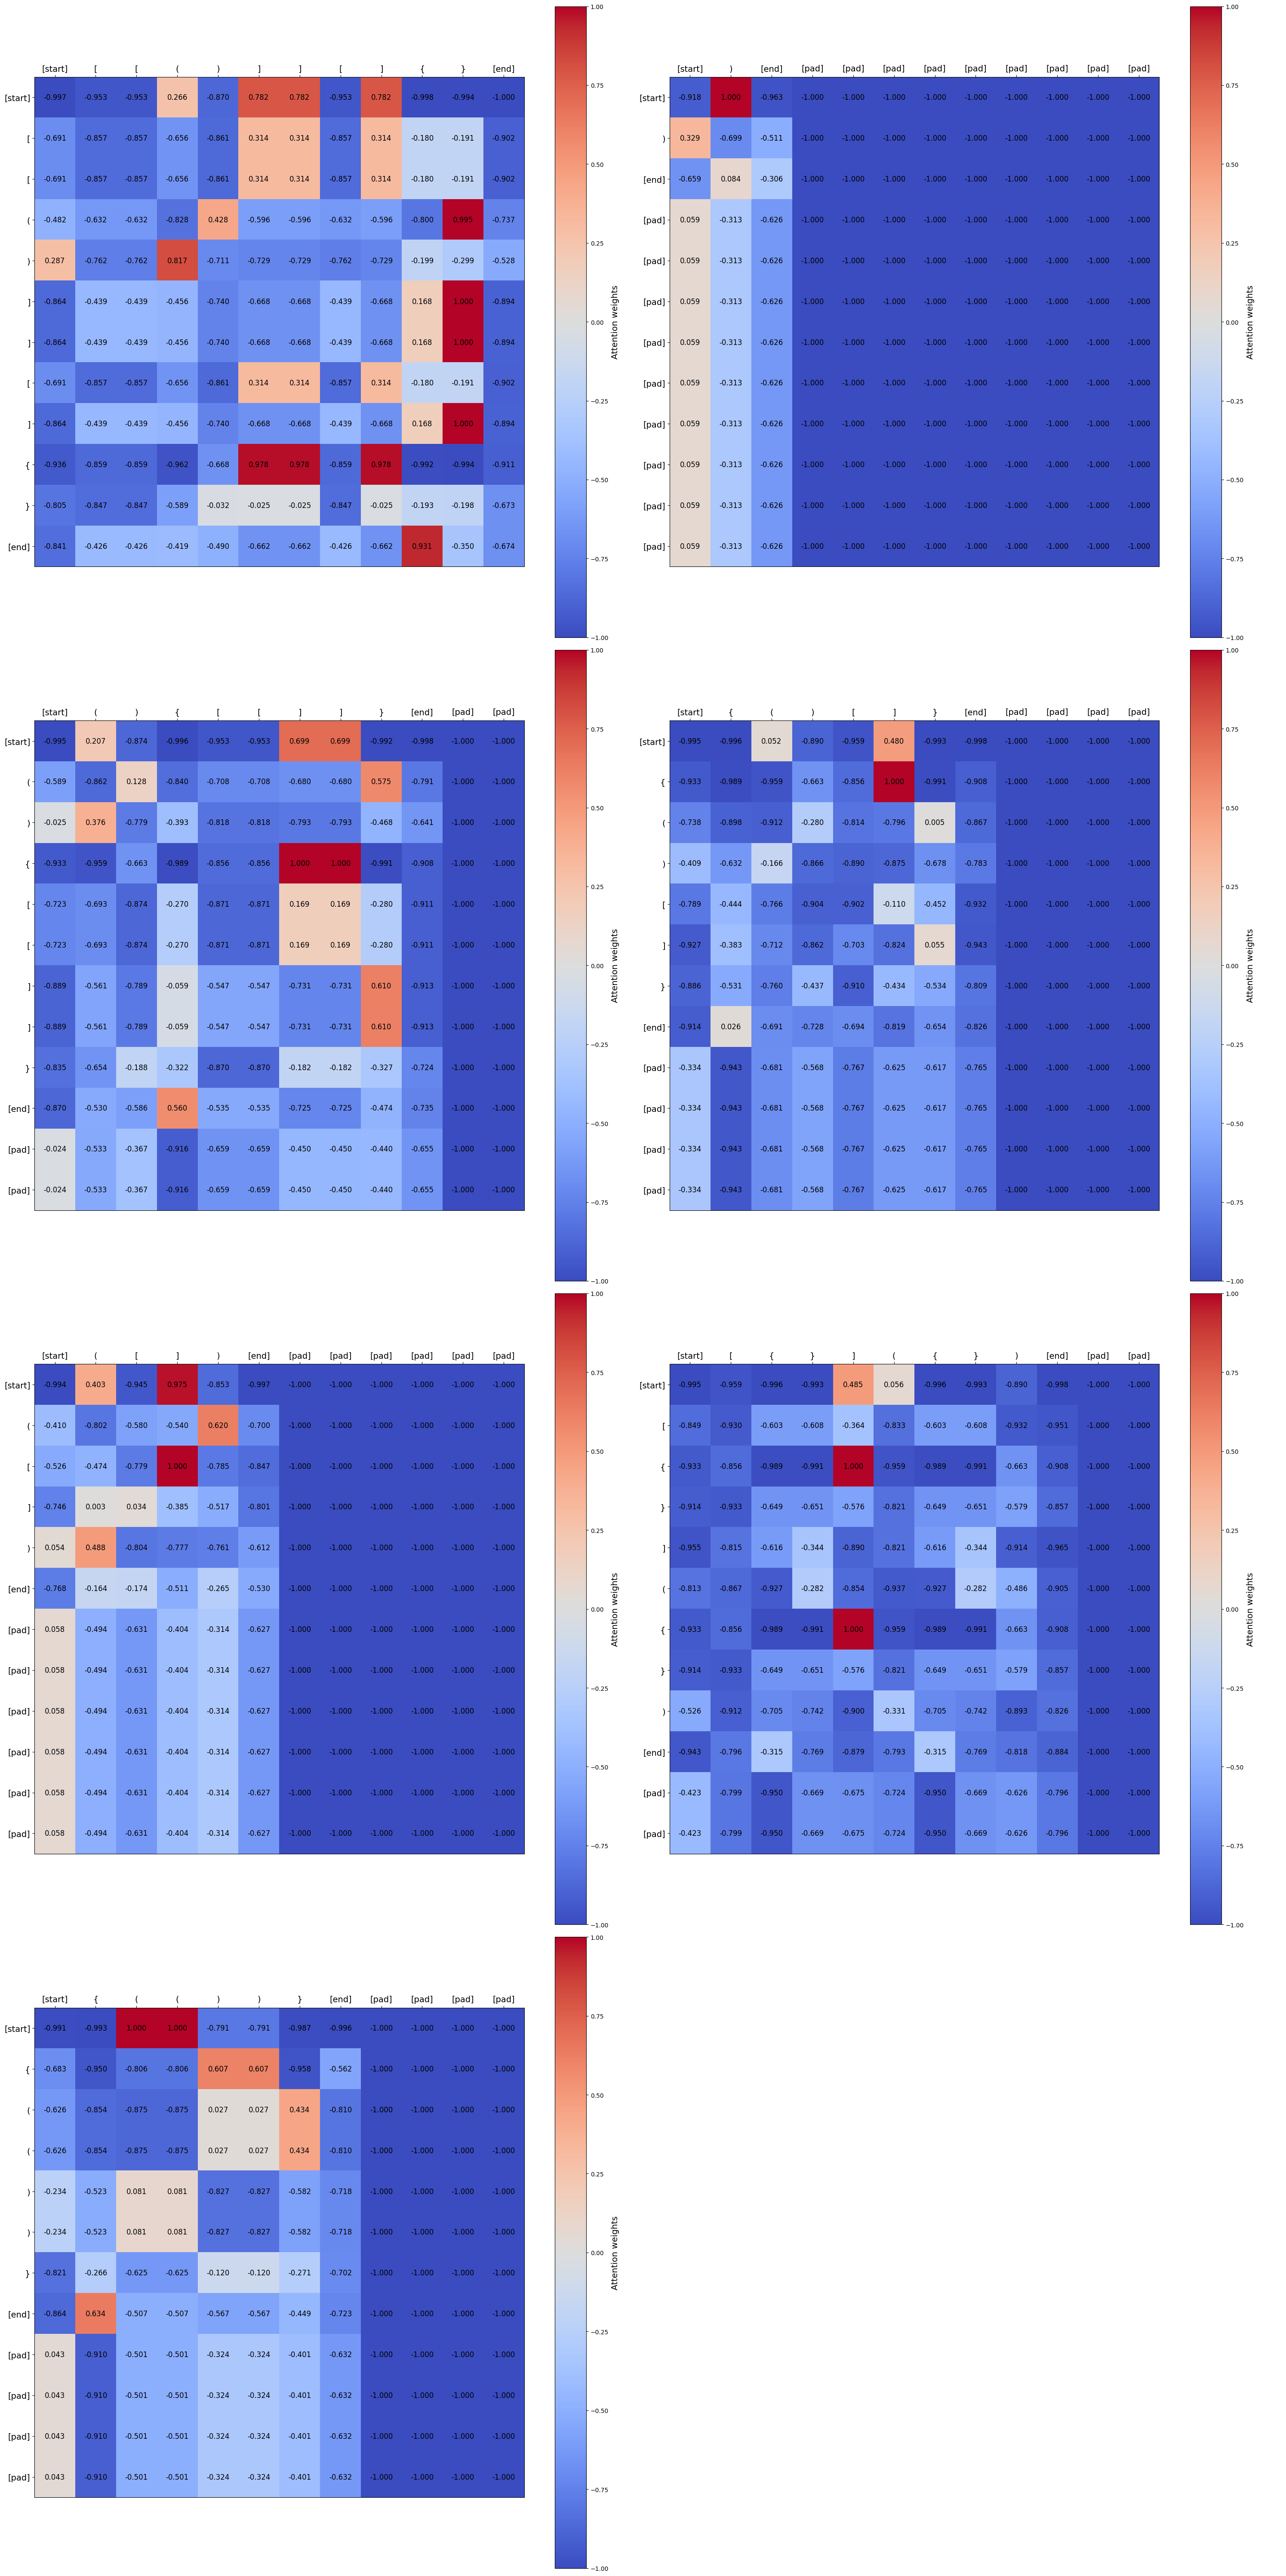

In [60]:
plot_attn_matrices(VOCAB, batch, model, min_max_normalize, pad_token_mask)